## **Import the Required Libraries**

In [2]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from tensorflow.keras.regularizers import l2
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

Let's download the source file and extract it.

In [3]:
import os
# Downloading the dataset zip file
if (not os.path.exists("rus-engy.zip")):
  # Download the dataset file if not exists
  !wget http://www.manythings.org/anki/rus-eng.zip

!unzip rus-eng.zip

--2021-08-09 08:13:37--  http://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.92.44, 172.67.186.54, 2606:4700:3033::ac43:ba36, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.92.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14385451 (14M) [application/zip]
Saving to: ‘rus-eng.zip.1’

rus-eng.zip.1       100%[===================>]  13.72M  5.50MB/s    in 2.5s    

2021-08-09 08:13:40 (5.50 MB/s) - ‘rus-eng.zip.1’ saved [14385451/14385451]

Archive:  rus-eng.zip
replace rus.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: rus.txt                 
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: _about.txt              


In [4]:
# Check the contents of the file
file = open("rus.txt", "r")
lines = file.readlines()
for i in range(5):
  print(lines[i])

Go.	Марш!	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)

Go.	Иди.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898247 (marafon)

Go.	Идите.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898250 (marafon)

Hi.	Здравствуйте.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #402127 (odexed)

Hi.	Привет!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #466968 (katjka)



## **Load the Data file and extract the Language pairs**
Now load the `.txt` file which contains the English and Russian sentences and other information and extract the English-Russian Language pairs only by leaving the remaining data.

In [5]:
def load_file_into_pairs(file_name):
  # Opening the File in Readmode
  file_here = open(file_name, mode = 'rt', encoding = 'utf-8')
  # Reading all the lines of the file
  text = file_here.read()
  # Close the file
  file_here.close()
  
  # Extracting the sentences from the whole text
  lines = text.strip().split('\n')
  # Splitting the values by tab indentation
  pairs = [line.split('\t') for line in lines]
  return pairs

In [6]:
# Now load the .txt file and read language pairs
file_name = "rus.txt"
data_pairs = load_file_into_pairs(file_name)
data_pairs = array(data_pairs)
# Check the language pairs
for i in range(5):
  print(data_pairs[i])

['Go.' 'Марш!'
 'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)']
['Go.' 'Иди.'
 'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898247 (marafon)']
['Go.' 'Идите.'
 'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898250 (marafon)']
['Hi.' 'Здравствуйте.'
 'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #402127 (odexed)']
['Hi.' 'Привет!'
 'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #466968 (katjka)']


The actual data contains over 4,31,097 sentence-pairs. But for now, we will use the first 50,000 sentence pairs only to reduce the training time of the model.

In [7]:
data_pairs = data_pairs[:50000, :]

## **Text Pro-processing Steps**
### **Text Cleaning**
#### **1. Removinga the punctuation marks**
As we have observed many punctuations at the end of sentences let's get rid off of them first. 


In [8]:
#Split the Data pairs into Input data (features) and Output data (labels)
rus = data_pairs[:, 1]
eng = data_pairs[:, 0]

# Remove punctuation
rus = [s.translate(str.maketrans('', '', string.punctuation)) for s in rus]
eng = [s.translate(str.maketrans('', '', string.punctuation)) for s in eng]

#### **2. Converting the words to Lower Case**
The sentences have words that are starting with upper case letters, so we have to convert them all into lower case ones.

In [9]:
# Convert to Lower Case
for i in range(len(data_pairs)):
    rus[i] = rus[i].lower()
    eng[i] = eng[i].lower()

### **Text to Sequence Conversion**
To feed the processed data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. 

In [10]:
# Let's visualise the length of the sentences
eng_len = [len(word.split()) for word in eng]
rus_len = [len(word.split()) for word in rus]

In [11]:
print(f"The maximum length of English sentences is {max(eng_len)}. \nThe maximum length of Russian sentence is {max(rus_len)}.")
print("\nSentences with max length are:")
print(eng[argmax(rus_len)])
print(rus[argmax(rus_len)])

The maximum length of English sentences is 6. 
The maximum length of Russian sentence is 10.

Sentences with max length are:
money talks
деньги есть — иван петрович денег нет — паршивый сволочь


The maximum length of the Russian sentences is 10 and that of the English sentences is 6.

### **Tokenization**

Now its time to vectorize our text data by using Keras's `Tokenizer()` class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [12]:
min_of_both = min(max(eng_len), max(rus_len))
# Create English Tokenizer
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(eng)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = min_of_both

# Create Russian Tokenizer
rus_tokenizer = Tokenizer()
rus_tokenizer.fit_on_texts(rus)
rus_vocab_size = len(rus_tokenizer.word_index) + 1
rus_length = min_of_both

# Print the sizes of vocabulary
print(f"English Vocabulary Size: {eng_vocab_size}\nRussian Vocabulary Size: {rus_vocab_size}")

English Vocabulary Size: 4979
Russian Vocabulary Size: 13609


## **Split the data into Train and Test Data**
We will now split the data into train and test set for model training and evaluation, respectively. Russian sentences are Input  and English sentences are outptu for the model.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(rus, eng, test_size = 0.2, random_state = 12)
X_test_actual = X_test
y_test_actual = y_test

In [14]:
# Create a method to prepare sequences
def encode_sequences(tokenizer, length, lines):
  # Integer encode sequences
  return pad_sequences(tokenizer.texts_to_sequences(lines), maxlen = length, padding = 'post') 

Now we will encode the sentences for both train and test datasets.

In [15]:
# Prepare training data
X_train = encode_sequences(rus_tokenizer, rus_length, X_train)
y_train = encode_sequences(eng_tokenizer, eng_length, y_train)

# Prepare testing data
X_test = encode_sequences(rus_tokenizer, rus_length, X_test)
y_test = encode_sequences(eng_tokenizer, eng_length, y_test)

## **Build Model**
Now let's define our Seq2Seq model architecture. We will be using an Embedding layer and an LSTM layer as our Encoder and another LSTM layer followed by a Dense layer as the Decoder.


In [73]:
units = 512
# Build the Model
model = Sequential()
model.add(Embedding(rus_vocab_size, units, input_length = rus_length, mask_zero = True))
model.add(LSTM(units))
#model.add(LSTM(units, kernel_regularizer = l2(0.001)))
model.add(Dropout(0.2))
model.add(RepeatVector(eng_length))
model.add(LSTM(units, return_sequences = True))
model.add(Dense(eng_vocab_size, activation = 'softmax'))

## **Compile the Model**
We will use `RMSprop` optimizer and `sparse_categorical_crossentropy` loss function in this model as it is a good choice for RNNs.

In [74]:
model.compile(
    optimizer = optimizers.RMSprop(learning_rate=0.001), 
    loss = 'sparse_categorical_crossentropy', 
    metrics = ['accuracy']
)

## **Summarize the Model**

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 6, 512)            6967808   
_________________________________________________________________
lstm_22 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
repeat_vector_11 (RepeatVect (None, 6, 512)            0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 6, 512)            2099200   
_________________________________________________________________
dense_11 (Dense)             (None, 6, 4979)           2554227   
Total params: 13,720,435
Trainable params: 13,720,435
Non-trainable params: 0
_________________________________________

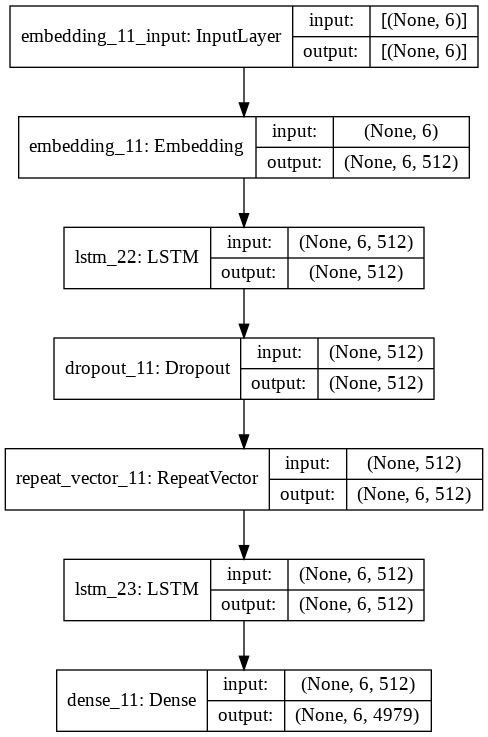

In [75]:
# Summarize the defined Model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

## **Train the Model**
We will train the model for 30 epochs  with a batch size of 512. You may change and play these hyperparameters. We will also be using `ModelCheckpoint()` to save the best model with lowest validation loss. 

In [76]:
# Give a filename to save the model
model_filename = 'model.h5'

# Create a checkpoin to stop training based on minimum validation loss
checkpoint = ModelCheckpoint(
    model_filename, 
    monitor='val_loss',
    mode = 'min',
    verbose = 1, 
    save_best_only = True
)

# Start training on Train
history = model.fit(
    X_train, 
    y_train.reshape(y_train.shape[0], y_train.shape[1], 1), 
    epochs=30, 
    batch_size=512, 
    validation_split = 0.2,
    callbacks=[checkpoint], 
    verbose=1
)

Epoch 1/30
63/63 [==============================] - 10s 90ms/step - loss: 4.8300 - accuracy: 0.4266 - val_loss: 3.3205 - val_accuracy: 0.4860

Epoch 00001: val_loss improved from inf to 3.32048, saving model to model.h5
Epoch 2/30
63/63 [==============================] - 4s 58ms/step - loss: 3.2243 - accuracy: 0.4867 - val_loss: 3.1560 - val_accuracy: 0.4981

Epoch 00002: val_loss improved from 3.32048 to 3.15600, saving model to model.h5
Epoch 3/30
63/63 [==============================] - 4s 57ms/step - loss: 3.0391 - accuracy: 0.5045 - val_loss: 2.9037 - val_accuracy: 0.5312

Epoch 00003: val_loss improved from 3.15600 to 2.90365, saving model to model.h5
Epoch 4/30
63/63 [==============================] - 4s 57ms/step - loss: 2.7884 - accuracy: 0.5367 - val_loss: 2.7660 - val_accuracy: 0.5513

Epoch 00004: val_loss improved from 2.90365 to 2.76599, saving model to model.h5
Epoch 5/30
63/63 [==============================] - 4s 58ms/step - loss: 2.5911 - accuracy: 0.5580 - val_loss: 

The model has performed well for 30 epochs with accuracy of 97.25% and validation accuracy of 91.08%

Let's compare the training and the validation metrics.

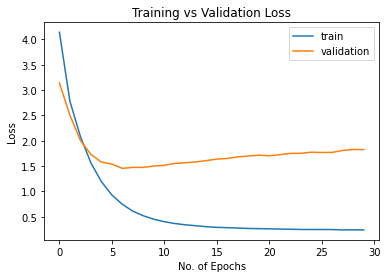

In [68]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.title('Training vs Validation Loss')
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.show()

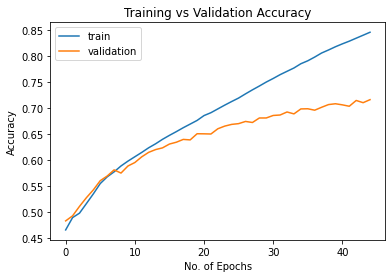

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','validation'])
plt.title('Training vs Validation Accuracy')
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.show()

## **Make Predictions**
We have successfully created the model, compiled and trained it well. We have achieved good accuracy and minimum validation loss. It's time to make some real predictions on our Test data. Let's load the saved model to make predictions.<br>
Let's load the saved model to get predictions on input text.

In [ ]:
# Loading already saved model
loaded_model = load_model('model.h5')

Now get the predictions of all the Test data and save it. Later we will use it for cross referencing with our Actual data.

In [ ]:
# Let's make predictions on our Test data and verify the results
preds = argmax(loaded_model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1]))), axis=-1)

In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

Now we will create a Dataframe for the Actual sentences and Predicted sentences to check how well our model is performing.

In [ ]:
pred_df = pd.DataFrame({'Actual' : y_test_actual, 'Predicted' : preds_text})

The Dataframe is created and we will compare the predictions with actual data.

In [ ]:
pd.set_option('display.max_colwidth', 200)

Let's check the first 10 sentences of Dataframe.

In [ ]:
# Display top 10 rows
pred_df.head(10)

Let's check the last 10 sentences of Dataframe.

In [ ]:
# Display bottom 10 rows
pred_df.tail(10)

Let's check some random sentences of Dataframe.

In [ ]:
# Display random samples
pred_df.sample(10)

## **Make Predictions on Custom Data Input**
Its time to have real fun. We have already created the model, trained it and tested it. Finally all looks good. Now we will take a custom input and try to translate it into English.

In [ ]:
# Create a method to translate the Russian word into English
def decode_output(text_in):
  text_in = array([text_in])
  # Input text proprecessing
  # Remove punctuation
  text_in = [s.translate(str.maketrans('', '', string.punctuation)) for s in text_in]
  #text_in = "".join(text_in)
  # Convert to Lower Case
  for i in range(len(text_in)):
    text_in[i] = text_in[i].lower()
  # Encoding the sequence
  text_in = encode_sequences(rus_tokenizer, rus_length, text_in)
  # Getting predictions on single input sentence
  preds = argmax(loaded_model.predict(text_in.reshape(text_in.shape[0], text_in.shape[1])), axis=-1)
  def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

  # Convert predictions into text (English)
  preds_text = []
  for i in preds:
      temp = []
      for j in range(len(i)):
          t = get_word(i[j], eng_tokenizer)
          if j > 0:
              if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                  temp.append('')
              else:
                  temp.append(t)             
          else:
              if(t == None):
                  temp.append('')
              else:
                  temp.append(t)       
      preds_text.append(' '.join(temp))
  return preds_text[0].strip()

In [ ]:
# Input text
text_in = "Входи!"
text_out = decode_output(text_in)
print(f"The input Russian sentence is : {text_in}")
print(f"The output English sentence is: {text_out}")